In [1]:
# THIS SCRIPT TAKES ALL ALPHAPOSE RESULTS AND FILTERS THEM SUCH THAT EACH ANNOTATION FILE IS SPLIT INTO PERSON 1 AND PERSON 2


# - Load oringinal annotations
# - create bounding boxes for each image
# - predictions closest to bounding box are saved, others are filtered out

In [2]:
from collections import Counter

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pickle as pkl
import os

In [3]:
with open(r"E:\Users\Philipp\Dokumente\Pose_Estimation_3D\MotionBert\MotionBERT\data\mesh\mesh_det_pw3d.pkl", 'rb') as f:
    dataset_pw3d = pkl.load(f)

In [4]:
with open(r"E:\Users\Philipp\Dokumente\Pose_Estimation_3D\3DPW\sequenceFiles\sequenceFiles\test\downtown_upstairs_00.pkl", 'rb') as f:
    dataset_original_dt_arguing = pkl.load(f, encoding='latin1')

In [5]:
len(dataset_original_dt_arguing['poses2d'][0])

845

In [6]:
import os
import cv2
import numpy as np
import pickle

def pw3d_extract(dataset_path, out_path):

    # scale factor
    scaleFactor = 1.2

    # structs we use
    imgnames_, scales_, centers_, parts_, bboxs_,poses_2d_, all_img_names_, all_poses_2d_ = [], [], [], [], [], [], [], []
    poses_, shapes_, genders_ = [], [], [] 

    # get a list of .pkl files in the directory
    dataset_path = os.path.join(dataset_path, 'sequenceFiles', 'test')
    files = [os.path.join(dataset_path, f) 
        for f in os.listdir(dataset_path) if f.endswith('.pkl')]
    # go through all the .pkl files
    for filename in files:
        with open(filename, 'rb') as f:
            data = pickle.load(f, encoding='latin1')
            smpl_pose = data['poses']
            smpl_betas = data['betas']
            poses2d = data['poses2d']
            global_poses = data['cam_poses']
            genders = data['genders']
            valid = np.array(data['campose_valid']).astype(np.bool)
            num_people = len(smpl_pose)
            num_frames = len(smpl_pose[0])
            seq_name = str(data['sequence'])
            img_names = np.array(['imageFiles/' + seq_name + '/image_%s.jpg' % str(i).zfill(5) for i in range(num_frames)])
            # get through all the people in the sequence
            for i in range(num_people):
                valid_pose = smpl_pose[i][valid[i]]
                valid_betas = np.tile(smpl_betas[i][:10].reshape(1,-1), (num_frames, 1))
                valid_betas = valid_betas[valid[i]]
                valid_keypoints_2d = poses2d[i][valid[i]]
                valid_img_names = img_names[valid[i]]
                valid_global_poses = global_poses[valid[i]]
                gender = genders[i]
                # consider only valid frames
                for valid_i in range(valid_pose.shape[0]):
                    part = valid_keypoints_2d[valid_i,:,:].T
                    part = part[part[:,2]>0,:]
                    bbox = [min(part[:,0]), min(part[:,1]),
                        max(part[:,0]), max(part[:,1])]
                    center = [(bbox[2]+bbox[0])/2, (bbox[3]+bbox[1])/2]
                    scale = scaleFactor*max(bbox[2]-bbox[0], bbox[3]-bbox[1])/200
                    
                    # transform global pose
                    pose = valid_pose[valid_i]
                    extrinsics = valid_global_poses[valid_i][:3,:3]
                    pose[:3] = cv2.Rodrigues(np.dot(extrinsics, cv2.Rodrigues(pose[:3])[0]))[0].T[0]                      

                    
                    imgnames_.append(valid_img_names[valid_i])
                    centers_.append(center)
                    scales_.append(scale)
                    poses_.append(pose)
                    shapes_.append(valid_betas[valid_i])
                    genders_.append(gender)
                    bboxs_.append(bbox)
                    poses_2d_.append(part)
            all_poses_2d_.append(poses2d)
            all_img_names_.append(img_names)

                    

    # store data
    if not os.path.isdir(out_path):
        os.makedirs(out_path)
    out_file = os.path.join(out_path,
        '3dpw_test.npz')
    np.savez(out_file, imgname=imgnames_,
                       center=centers_,
                       scale=scales_,
                       pose=poses_,
                       shape=shapes_,
                       gender=genders_,
                       bbox = bboxs_,
                       poses_2d = poses_2d_,
                       all_img_names = all_img_names_,
                       all_poses_2d = all_poses_2d_)

In [7]:
pw3d_extract(r'E:\Users\Philipp\Dokumente\Pose_Estimation_3D\3DPW\sequenceFiles', r'E:\Users\Philipp\Dokumente\Pose_Estimation_3D\3DPW\preprocessed_test')

e:\miniconda-envs\alphapose2\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
e:\miniconda-envs\alphapose2\lib\site-packages\numpy\lib\npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [8]:
threedpw_test = np.load(r"E:\Users\Philipp\Dokumente\Pose_Estimation_3D\3DPW\preprocessed_test\3dpw_test.npz", allow_pickle=True) # preprocessed by SPIN

In [9]:
threedpw_test.files

['imgname',
 'center',
 'scale',
 'pose',
 'shape',
 'gender',
 'bbox',
 'poses_2d',
 'all_img_names',
 'all_poses_2d']

In [10]:
len(threedpw_test['all_poses_2d'][15][0])

1387

In [11]:
# Problem: 15 and 16 are switched

In [12]:
threedpw_test['all_poses_2d'][2][1][150]  # threedpw_test['all_poses_2d'][idxfile][idxperson][idxframe]

array([[1.458910e+02, 2.651460e+02, 1.455670e+02, 9.880560e+01,
        1.535380e+01, 3.642760e+02, 3.796960e+02, 2.964750e+02,
        1.352350e+02, 1.145130e+02, 1.767320e+02, 2.758800e+02,
        2.653120e+02, 2.707510e+02, 0.000000e+00, 1.925000e+02,
        0.000000e+00, 2.913740e+02],
       [3.756300e+02, 6.467810e+02, 6.416380e+02, 8.867940e+02,
        1.048660e+03, 6.470650e+02, 9.808050e+02, 1.226310e+03,
        1.168630e+03, 1.481900e+03, 1.721730e+03, 1.189460e+03,
        1.523540e+03, 1.852190e+03, 0.000000e+00, 3.495950e+02,
        0.000000e+00, 3.967450e+02],
       [8.655200e-01, 8.286700e-01, 8.709030e-01, 7.974720e-01,
        4.071380e-01, 7.230970e-01, 8.598930e-01, 7.901490e-01,
        5.956160e-01, 6.796890e-01, 6.969150e-01, 5.691110e-01,
        7.473780e-01, 7.654930e-01, 0.000000e+00, 1.831370e-01,
        0.000000e+00, 1.718988e-01]])

In [13]:
# next: plot image with these coords

In [14]:
threedpw_test['all_img_names'][2][-1] #threedpw_test['all_img_names'][idxfile][idxframe]

'imageFiles/downtown_bus_00/image_02177.jpg'

In [15]:
len(threedpw_test['imgname'])

35515

In [16]:
threedpw_test['all_poses_2d'][2][1][116].T

array([[1.292650e+01, 3.967970e+02, 9.107910e-01],
       [1.458890e+02, 6.468990e+02, 8.476730e-01],
       [4.156660e+01, 6.573230e+02, 6.671470e-01],
       [1.534000e+01, 9.704140e+02, 9.002430e-02],
       [0.000000e+00, 0.000000e+00, 0.000000e+00],
       [2.705550e+02, 6.416590e+02, 8.095890e-01],
       [3.226940e+02, 9.338990e+02, 8.446530e-01],
       [2.654300e+02, 1.189470e+03, 8.931410e-01],
       [0.000000e+00, 0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00],
       [1.926320e+02, 1.194770e+03, 5.863800e-01],
       [2.185920e+02, 1.533890e+03, 7.468100e-01],
       [3.434900e+02, 1.726870e+03, 8.014780e-01],
       [1.539220e+01, 3.913730e+02, 4.359860e-02],
       [5.729460e+01, 3.704430e+02, 1.739588e-01],
       [0.000000e+00, 0.000000e+00, 0.000000e+00],
       [1.508950e+02, 4.019440e+02, 1.718528e-01]])

In [17]:
threedpw_test['imgname']

array(['imageFiles/downtown_arguing_00/image_00000.jpg',
       'imageFiles/downtown_arguing_00/image_00001.jpg',
       'imageFiles/downtown_arguing_00/image_00002.jpg', ...,
       'imageFiles/outdoors_fencing_01/image_00939.jpg',
       'imageFiles/outdoors_fencing_01/image_00940.jpg',
       'imageFiles/outdoors_fencing_01/image_00941.jpg'], dtype='<U53')

In [18]:
def calculate_min_bounding_box(keypoints):
    """
    Calculate the minimal bounding box that encapsulates the given keypoints,
    excluding (0, 0) coordinates.
    
    Parameters:
    - keypoints: A numpy array of shape (N, 2), where N is the number of keypoints.
    
    Returns:
    - bbox: A tuple containing the coordinates of the bounding box (min_x, min_y, max_x, max_y),
      or None if all keypoints are filtered out.
    """
    import numpy as np

    # Ensure keypoints is a numpy array
    keypoints = np.array(keypoints)

    # Filter out (0, 0) coordinates
    filtered_keypoints = keypoints[(keypoints[:, 0] != 0) | (keypoints[:, 1] != 0)]

    # Check if there are any valid keypoints left
    if filtered_keypoints.size == 0:
        return None  # No bounding box if all keypoints are invalid

    # Get min and max for x and y coordinates
    min_x = np.min(filtered_keypoints[:, 0])
    min_y = np.min(filtered_keypoints[:, 1])
    max_x = np.max(filtered_keypoints[:, 0])
    max_y = np.max(filtered_keypoints[:, 1])

    # Bounding box coordinates: (min_x, min_y, max_x, max_y)
    bbox = (min_x, min_y, max_x, max_y)
    return bbox


In [19]:
poses_2d = threedpw_test['all_poses_2d'][0][0][0].T

bbox = calculate_min_bounding_box(poses_2d)

In [20]:
len(threedpw_test['all_poses_2d'][16][0])

388

In [21]:
# Initialize a container for all files (37 total)
all_bboxes = []

for file_idx, file_data in enumerate(threedpw_test['all_poses_2d']):
    file_bboxes = []

    for person_idx, person_data in enumerate(file_data):  # Adjust based on structure
        person_boxes = []

        for frame in person_data:  # Iterate over frames
            poses_2d = frame.T
            bbox = calculate_min_bounding_box(poses_2d)
            
            # If bbox is None, replace it with (0, 0, 0, 0)
            if bbox is None:
                bbox = (0, 0, 0, 0)

            person_boxes.append(bbox)

        file_bboxes.append(person_boxes)

    all_bboxes.append(file_bboxes)


In [22]:
len(all_bboxes[0][0])

898

In [23]:
threedpw_test['all_poses_2d'][0][0].shape

(898, 3, 18)

In [24]:
def get_file_name(idx):

    string = dataset_pw3d['test']['source'][idx]

    # Person index
    last_digit = string[-1]

    # File index
    second_digit = string[-2]

    new_string = string[:-3] + f'0{second_digit}'

    return new_string

In [25]:
file_names = []
nr_persons = []

for idx, elem in enumerate(dataset_pw3d['test']['source']):
    file_names.append(get_file_name(idx))

In [26]:
# indices

set(file_names)

{'downtown_arguing_00',
 'downtown_bar_00',
 'downtown_bus_00',
 'downtown_cafe_00',
 'downtown_car_00',
 'downtown_crossStreets_00',
 'downtown_downstairs_00',
 'downtown_enterShop_00',
 'downtown_rampAndStairs_00',
 'downtown_runForBus_00',
 'downtown_runForBus_01',
 'downtown_sitOnStairs_00',
 'downtown_stairs_00',
 'downtown_upstairs_00',
 'downtown_walkBridge_01',
 'downtown_walkUphill_00',
 'downtown_walking_00',
 'downtown_warmWelcome_00',
 'downtown_weeklyMarket_00',
 'downtown_windowShopping_00',
 'flat_guitar_01',
 'flat_packBags_00',
 'office_phoneCall_00',
 'outdoors_fencing_01'}

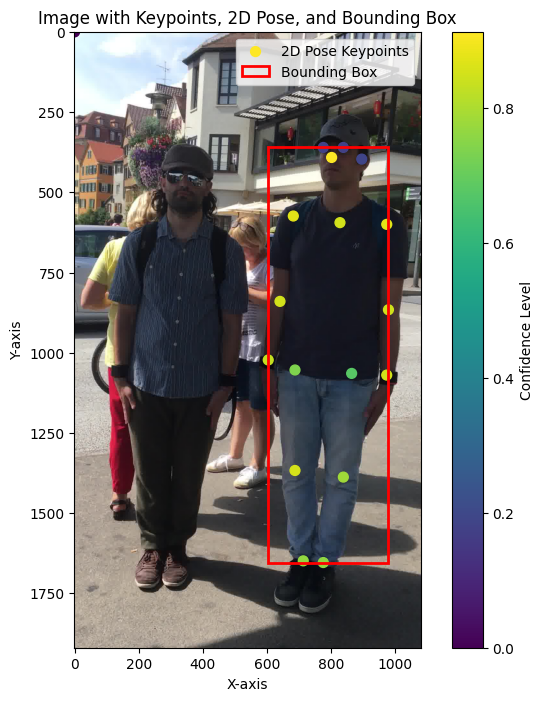

In [27]:
import matplotlib.patches as patches
import matplotlib.image as mpimg
# problem: images with two persons are in twice
file_idx = 2
frame_idx = 0
person_idx = 0

root = r'E:\Users\Philipp\Dokumente\Pose_Estimation_3D\3DPW\imageFiles'

image_path = threedpw_test['all_img_names'][file_idx][frame_idx]
image_path = os.path.join(root, image_path)
image = mpimg.imread(image_path)

poses_2d = threedpw_test['all_poses_2d'][file_idx][person_idx][frame_idx].T

x_coords = poses_2d[:, 0]  # X-coordinates
y_coords = poses_2d[:, 1]  # Y-coordinates
confidence = poses_2d[:, 2]  # Confidence levels

bbox = all_bboxes[file_idx][person_idx][frame_idx]


if bbox != None:
    # Extract bounding box coordinates
    x_min, y_min, width, height = bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]

# Plot the image
plt.figure(figsize=(8, 8))
plt.imshow(image)

# Plot the 2D pose keypoints with confidence-based coloring
scatter = plt.scatter(x_coords, y_coords, c=confidence, cmap='viridis', s=50, label='2D Pose Keypoints')

# Add colorbar to represent confidence levels
plt.colorbar(scatter, label='Confidence Level')

if bbox != None:
    # Add bounding box to the plot
    bbox_rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none', label='Bounding Box')
    plt.gca().add_patch(bbox_rect)

# Add labels, title, and legend
plt.title('Image with Keypoints, 2D Pose, and Bounding Box')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()


In [28]:
#NEED TO FIND OUT FOR WHICH FRAMES THERE ARE NO 2D POSE ANNOTATIONS

In [29]:
#second digit: index of file, third digit, index of person

In [30]:
import json
input_file = r"../examples/res/test_set/downtown_bar_00/alphapose-results.json"
with open(input_file, 'r') as f:
    data = json.load(f)

In [31]:
# 26 keypoints with a confidence value each
data[0].keys()

dict_keys(['image_id', 'category_id', 'keypoints', 'score', 'box', 'idx'])

In [32]:
### Go through detections, filter out two detections which are most similar to the ground truth for every frame

np.asarray(data[0]['keypoints']).shape

#data[i]['keypoints']

(78,)

In [33]:
true_bbox = all_bboxes[0][0][0]

In [34]:
def closest_keypoints_to_bbox(keypoint_sets, true_bbox):
    """
    Find the keypoint set whose minimal bounding box is closest to the true bounding box.

    Parameters:
        keypoint_sets (list): List of keypoint sets, where each set is in the format [x1, y1, c1, ...].
        true_bbox (tuple): Ground truth bounding box in the format (x_min, y_min, x_max, y_max).

    Returns:
        list: Keypoint set with the closest bounding box.
    """
    def calculate_bbox(keypoints):
        coords = [(keypoints[i], keypoints[i + 1]) for i in range(0, len(keypoints), 3)]
        x_coords, y_coords = zip(*coords)
        return min(x_coords), min(y_coords), max(x_coords), max(y_coords)

    def bbox_center(bbox):
        x_min, y_min, x_max, y_max = bbox
        return ((x_min + x_max) / 2, (y_min + y_max) / 2)

    true_center = bbox_center(true_bbox)
    
    closest_keypoints = None
    min_distance = float('inf')

    for keypoints in keypoint_sets:
        bbox = calculate_bbox(keypoints)
        center = bbox_center(bbox)
        distance = np.sqrt((center[0] - true_center[0])**2 + (center[1] - true_center[1])**2)

        if distance < min_distance:
            min_distance = distance
            closest_keypoints = keypoints

    return closest_keypoints

In [35]:
def filter_duplicates(data, true_bboxes):
    from collections import defaultdict

    # Group dictionaries by image_id
    grouped_data = defaultdict(list)
    for entry in data:
        grouped_data[entry['image_id']].append(entry)

    # Prepare the filtered data list
    filtered_data = []

    # Process each group
    for idx, (image_id, entries) in enumerate(grouped_data.items()):
        true_bbox = true_bboxes[idx]  # Get the corresponding true bbox for the frame
        
        if len(entries) == 1:
            # If there's only one entry for this image_id, add it directly
            filtered_data.append(entries[0])
        else:
            # Extract keypoints and apply closest_keypoints_to_bbox
            keypoint_sets = [entry['keypoints'] for entry in entries]
            closest_keypoints = closest_keypoints_to_bbox(keypoint_sets, true_bbox)

            # Find the entry with the matching keypoints and add it
            for entry in entries:
                if entry['keypoints'] == closest_keypoints:
                    filtered_data.append(entry)
                    break

    return filtered_data

In [36]:
filtered_data_p0 = filter_duplicates(data,all_bboxes[1][0])
filtered_data_p1 = filter_duplicates(data,all_bboxes[1][1])

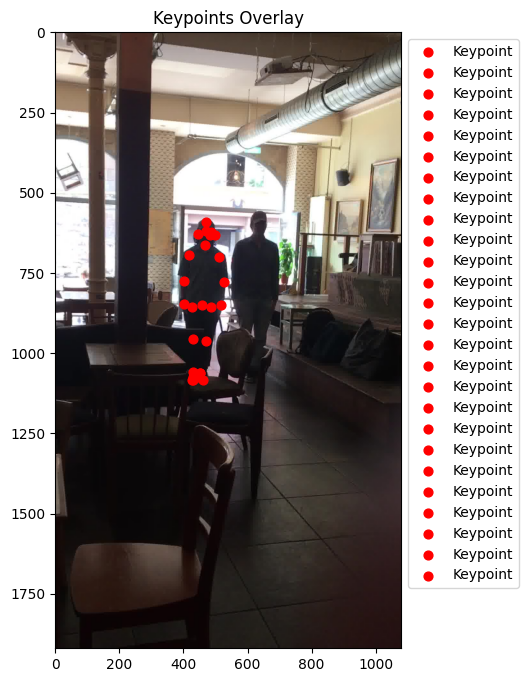

In [37]:
image_path = r"E:\Users\Philipp\Dokumente\Pose_Estimation_3D\3DPW\imageFiles\imageFiles\downtown_bar_00\image_00000.jpg"

# Load the image
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

# Convert the image to RGB for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Extract the keypoints
keypoints = filtered_data_p1[0]['keypoints']

coordinates = [(keypoints[i], keypoints[i + 1]) for i in range(0, len(keypoints), 3)]


# Plot the image and keypoints
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
for x, y in coordinates:
    plt.scatter(x, y, c='red', s=40, label="Keypoint")

# Ensure labels don't overlap
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.axis('on')
plt.title("Keypoints Overlay")
plt.show()

In [38]:
unique_file_names = list(dict.fromkeys(file_names))

unique_file_names

['downtown_arguing_00',
 'downtown_bar_00',
 'downtown_bus_00',
 'downtown_cafe_00',
 'downtown_car_00',
 'downtown_crossStreets_00',
 'downtown_downstairs_00',
 'downtown_enterShop_00',
 'downtown_rampAndStairs_00',
 'downtown_runForBus_00',
 'downtown_runForBus_01',
 'downtown_sitOnStairs_00',
 'downtown_stairs_00',
 'downtown_upstairs_00',
 'downtown_walkBridge_01',
 'downtown_walkUphill_00',
 'downtown_walking_00',
 'downtown_warmWelcome_00',
 'downtown_weeklyMarket_00',
 'downtown_windowShopping_00',
 'flat_guitar_01',
 'flat_packBags_00',
 'office_phoneCall_00',
 'outdoors_fencing_01']

In [39]:
switch = unique_file_names[15]

unique_file_names[15] = unique_file_names[16]
unique_file_names[16] = switch

In [40]:
import os
import json

def save_annot(filtered_data_p0, filtered_data_p1, folder_path):
    # Save filtered_data_p0 as 'person1.json', overwriting if it exists
    if filtered_data_p0 is not None:
        person1_path = os.path.join(folder_path, 'person_1.json')
        with open(person1_path, 'w') as json_file:
            json.dump(filtered_data_p0, json_file, indent=4)
        print(f"Saved person1 data to {person1_path}")

    # Save filtered_data_p1 as 'person2.json', overwriting if it exists
    if filtered_data_p1 is not None:
        person2_path = os.path.join(folder_path, 'person_2.json')
        with open(person2_path, 'w') as json_file:
            json.dump(filtered_data_p1, json_file, indent=4)
        print(f"Saved person2 data to {person2_path}")


In [41]:
# import os
# import json

# root_dir = r"E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set"

# # Example unique_file_names
# unique_file_names = ["folder1", "folder2"]  # Adjust to your actual folder names

# # Loop through subfolders
# for root, dirs, files in os.walk(root_dir):
#     print(f"Current root: {root}")
#     print(f"Directories before filtering: {dirs}")
    
#     # Filter `dirs` in-place to restrict traversal to only matching subfolders
#     dirs[:] = [d for d in dirs if d in unique_file_names]
#     print(f"Directories after filtering: {dirs}")
    
#     for d in dirs:
#         folder_index = unique_file_names.index(d)  # Get the index of the folder name in unique_file_names
#         print(f"Inspecting folder: {d}, index: {folder_index}")
        
#         for file in files:
#             print(f"Found file: {file}")
#             # Check if the file is a JSON file
#             if file.endswith('alphapose-results.json'):
#                 json_path = os.path.join(root, file)
#                 try:
#                     # Open and load the JSON file
#                     with open(json_path, 'r') as json_file:
#                         data = json.load(json_file)
#                         print(f"Loaded JSON from {json_path}")
#                 except Exception as e:
#                     print(f"Error reading {json_path}: {e}")

In [42]:
# path = "E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set\downtown_walking_00"

# for file in os.walk(path):

#             file_path = os.path.join(root, file)
#             print(f"Processing file: {file_path}")
#             # Check if the file is a JSON file
#             if file.endswith('alphapose-results.json'):
#                 json_path = os.path.join(root, file)
#                 try:
#                     # Open and load the JSON file
#                     with open(json_path, 'r') as json_file:
#                         data = json.load(json_file)

#                     folder_index = unique_file_names.index(current_path)
#                     # Use folder_index to access corresponding bounding boxes
#                     filtered_data_p0 = filter_duplicates(data, all_bboxes[folder_index][0])
#                     if len(all_bboxes[folder_index]) >= 2:
#                         filtered_data_p1 = filter_duplicates(data, all_bboxes[folder_index][1])

#                     # Uncomment and define save_annot to save the filtered data
#                     save_annot(filtered_data_p0, filtered_data_p1, os.path.join(root))


#                     filtered_data_p0 = None
#                     filtered_data_p1 = None
#                     print(f"Successfully processed and saved: {json_path}")

#                 except Exception as e:
#                     print(f"Error loading {json_path}: {e}")


In [43]:
import json
input_file = r"E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set\downtown_stairs_00\alphapose-results.json"
with open(input_file, 'r') as f:
    data = json.load(f)

In [44]:
# FIX FOLDER INDEX
# ALWAYS SAVING BOTH PERSONS LEADS TO THE FACT THAT IF THERE IS ONLY ! PERSON; THE PREVIOUS SECOND PERSON IS SAVED

# Path to the main directory
root_dir = r"E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set"


# Loop through subfolders
# Loop through subfolders
for root, dirs, files in os.walk(root_dir):
    # print(f"Current directory: {root}")
    # print(f"Subdirectories: {dirs}")
    # print(f"Files: {files}")
    filtered_data_p0 = None
    filtered_data_p1 = None
    current_path = os.path.basename(root)
    for file in files:
        filtered_data_p0 = None
        filtered_data_p1 = None
        file_path = os.path.join(root, file)
        print(f"Processing file: {file_path}")
        # Check if the file is a JSON file
        if file.endswith('alphapose-results.json'):
            json_path = os.path.join(root, file)
            try:
                # Open and load the JSON file
                with open(json_path, 'r') as json_file:
                    data = json.load(json_file)

                folder_index = unique_file_names.index(current_path)
                # Use folder_index to access corresponding bounding boxes
                filtered_data_p0 = filter_duplicates(data, all_bboxes[folder_index][0])
                if len(all_bboxes[folder_index]) >= 2:
                    filtered_data_p1 = filter_duplicates(data, all_bboxes[folder_index][1])

                # Uncomment and define save_annot to save the filtered data
                save_annot(filtered_data_p0, filtered_data_p1, os.path.join(root))


                filtered_data_p0 = None
                filtered_data_p1 = None
                print(f"Successfully processed and saved: {json_path}")

            except Exception as e:
                print(f"Error loading {json_path}: {e}")


Processing file: E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set\downtown_arguing_00\alphapose-results.json
Saved person1 data to E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set\downtown_arguing_00\person_1.json
Saved person2 data to E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set\downtown_arguing_00\person_2.json
Successfully processed and saved: E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set\downtown_arguing_00\alphapose-results.json
Processing file: E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set\downtown_arguing_00\AlphaPose_downtown_arguing_00.mp4
Processing file: E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set\downtown_arguing_00\person_1.json
Processing file: E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_

In [44]:
import json
input_file = r"E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set\downtown_warmWelcome_00\person_1.json"
with open(input_file, 'r') as f:
    split_res_p1 = json.load(f)

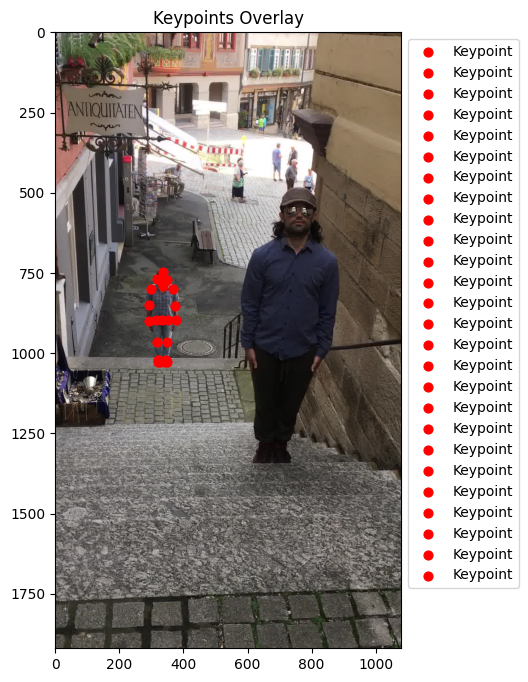

In [45]:
frame_idx = 0


image_path = r"E:\Users\Philipp\Dokumente\Pose_Estimation_3D\3DPW\imageFiles\imageFiles\downtown_warmWelcome_00\image_00000.jpg"


# Load the image
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

# Convert the image to RGB for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Extract the keypoints
keypoints = split_res_p1[frame_idx]['keypoints']

coordinates = [(keypoints[i], keypoints[i + 1]) for i in range(0, len(keypoints), 3)]


# Plot the image and keypoints
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
for x, y in coordinates:
    plt.scatter(x, y, c='red', s=40, label="Keypoint")

# Ensure labels don't overlap
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.axis('on')
plt.title("Keypoints Overlay")
plt.show()

In [46]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import json

# Parameters
root_folder = r"E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set"
image_root_folder = r"E:\Users\Philipp\Dokumente\Pose_Estimation_3D\3DPW\imageFiles\imageFiles"
fps = 30  # Frames per second for the output video
frame_file_format = "image_{:05d}.jpg"
scaling_factor = 0.5  # Scale down frames to reduce file size
max_frames = float('inf')  # Maximum number of frames to process for debugging

# Define codec
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Function to overlay keypoints on an image
def overlay_keypoints(image, keypoints):
    overlay = image.copy()
    for i in range(0, len(keypoints), 3):
        x, y, confidence = keypoints[i], keypoints[i + 1], keypoints[i + 2]
        if confidence > 0.5:  # Plot only keypoints with sufficient confidence
            cv2.circle(overlay, (int(x), int(y)), 5, (0, 0, 255), -1)
    return overlay

# Function to process and save video
def process_video(split_res, image_folder_path, output_video_path):
    frame_indices = range(min(len(split_res), max_frames))  # Process only up to max_frames

    # Load first frame to get dimensions
    first_frame_path = os.path.join(image_folder_path, frame_file_format.format(0))
    first_frame = cv2.imread(first_frame_path)
    if first_frame is None:
        raise FileNotFoundError(f"First frame not found at {first_frame_path}")

    # Scale down dimensions
    height, width, _ = first_frame.shape
    scaled_width = int(width * scaling_factor)
    scaled_height = int(height * scaling_factor)

    out = cv2.VideoWriter(output_video_path, fourcc, fps, (scaled_width, scaled_height))

    for frame_idx in frame_indices:
        # Load the frame
        frame_path = os.path.join(image_folder_path, frame_file_format.format(frame_idx))
        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"Frame not found at {frame_path}, skipping.")
            continue

        # Extract keypoints for the current frame
        keypoints = split_res[frame_idx]['keypoints']

        # Overlay keypoints on the frame
        frame_with_keypoints = overlay_keypoints(frame, keypoints)

        # Resize the frame to reduce file size
        frame_with_keypoints = cv2.resize(frame_with_keypoints, (scaled_width, scaled_height))

        # Write the frame to the video
        out.write(frame_with_keypoints)

    # Release the video writer
    out.release()
    print(f"Video saved at {output_video_path}")

# Loop through subfolders in the root folder
for subfolder in os.listdir(root_folder):
    subfolder_path = os.path.join(root_folder, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    image_folder_path = os.path.join(image_root_folder, subfolder)
    if not os.path.exists(image_folder_path):
        print(f"Image folder not found in {image_folder_path}, skipping.")
        continue

    # Process person_1.json
    person_1_file = os.path.join(subfolder_path, "person_1.json")
    if os.path.exists(person_1_file):
        with open(person_1_file, 'r') as f:
            split_res_p1 = json.load(f)
        output_video_path_1 = os.path.join(subfolder_path, "person_1.mp4")
        process_video(split_res_p1, image_folder_path, output_video_path_1)

    # Process person_2.json
    person_2_file = os.path.join(subfolder_path, "person_2.json")
    if os.path.exists(person_2_file):
        with open(person_2_file, 'r') as f:
            split_res_p2 = json.load(f)
        output_video_path_2 = os.path.join(subfolder_path, "person_2.mp4")
        process_video(split_res_p2, image_folder_path, output_video_path_2)


Video saved at E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set\downtown_arguing_00\person_1.mp4
Video saved at E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set\downtown_arguing_00\person_2.mp4
Video saved at E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set\downtown_bar_00\person_1.mp4
Video saved at E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set\downtown_bar_00\person_2.mp4
Video saved at E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set\downtown_bus_00\person_1.mp4
Video saved at E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set\downtown_bus_00\person_2.mp4
Video saved at E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\test_set\downtown_cafe_00\person_1.mp4
Video saved at E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphap

In [109]:
# Issues:
#downtown_downstairs_00 only has one json
# frames missing for downtown_stairs_00, probably because some frames have no detections (??) or missing images
# downtown_upstairs_00 wrong keypoints for person 2 -- fixed (no annotations in the first place)
# some vids have 2 json files even though only 1 person --fixed

## FIRST APPROACH

In [217]:
id = None
prev_id = None

for frame_data in data:
    id = frame_data['image_id']

    if prev_id == id:
        print(f'Double id for {id}')
        
    prev_id = id



Double id for 503.jpg
Double id for 507.jpg
Double id for 834.jpg
Double id for 839.jpg
Double id for 840.jpg
Double id for 1125.jpg
Double id for 1126.jpg


In [1224]:
def calculate_min_bounding_box(keypoints):
    """
    Calculate the minimal bounding box that encapsulates the given keypoints.
    
    Parameters:
    - keypoints: A numpy array of shape (N, 2), where N is the number of keypoints.
    
    Returns:
    - bbox: A tuple containing the coordinates of the bounding box (min_x, min_y, max_x, max_y).
    """
    # Ensure keypoints is a numpy array
    import numpy as np
    keypoints = np.array(keypoints)
    
    # Get min and max for x and y coordinates
    min_x = np.min(keypoints[:, 0])
    min_y = np.min(keypoints[:, 1])
    max_x = np.max(keypoints[:, 0])
    max_y = np.max(keypoints[:, 1])
    
    # Bounding box coordinates: (min_x, min_y, max_x, max_y)
    bbox = (min_x, min_y, max_x, max_y)
    return bbox

In [1225]:
dataset_pw3d['test']['bbox'] = []

for keypoints in dataset_pw3d['test']['joint_2d']:
    b_box = calculate_min_bounding_box(keypoints)
    dataset_pw3d['test']['bbox'].append(b_box)


In [1226]:
test_paths = []

root = r"E:\Users\Philipp\Dokumente\Pose_Estimation_3D\3DPW\imageFiles\imageFiles"
frame_count = 0  # Initialize frame_count outside the loop
prev_file_name = None  # Initialize prev_file_name outside the loop

for name in dataset_pw3d['test']['source']:
    number = name[-3:]
    file_idx = int(number[-2])
    person_idx = int(number[-1])
    file_name = name[0:-3] + str(0) + str(file_idx)

    # Reset frame_count if the file_name changes
    if file_name != prev_file_name:
        frame_count = 0

    path = os.path.join(root, file_name) 

    # Format the frame count to a 5-digit string with leading zeros
    image_filename = f'image_{frame_count:05d}.jpg'
    path = os.path.join(path, image_filename)

    frame_count += 1
    prev_file_name = file_name  # Update prev_file_name

    test_paths.append(path)



In [30]:
import json
input_file = r"../examples/res/downtown_bar_00/alphapose-results.json"
with open(input_file, 'r') as f:
    data = json.load(f)

In [31]:
def calc_img_scores_list(data):

    img_id_list = []
    scores_list = []

    for dict in data:
        img_id_list.append(dict['image_id'])
        scores_list.append(dict['score'])

    return img_id_list, scores_list

def calc_avg_n_people(img_id_list):

    # Count occurrences of each element
    element_counts = Counter(img_id_list)

    # Calculate average repetitions
    total_repeats = sum(element_counts.values())  # Total occurrences
    unique_elements = len(element_counts)         # Number of unique elements
    average_n_people = total_repeats / unique_elements if unique_elements > 0 else 0

    return average_n_people

In [32]:
# Filters data until we have annotations with an average of <= two people

def filter_until_two(data, average_n_people):

    threshhold = np.mean([entry['score'] for entry in data])

    filtered_data = data

    while average_n_people > 2: # Constantly correct threshhold until there are only two people 

        filtered_data = [entry for entry in data if entry.get('score', 0) >= threshhold]

        img_id_list = []
        scores_list = []

        for dict in filtered_data:
            img_id_list.append(dict['image_id'])
            scores_list.append(dict['score'])


        average_n_people =  calc_avg_n_people(img_id_list)


        # recalculate threshhold

        threshhold = np.percentile(scores_list, 90)

    return filtered_data, average_n_people



In [33]:
def spilt_json(filtered_data, average_n_people):

    # If we have more than one person, split the json file into two parts. 
    # Problem, if for one frame only one annotation, which file does it belong to.
    # Possible solution: compare bonding box consistency
    person_1 = []
    person_2 = []

    #if len(filtered_data) % 2 == 0:

    if average_n_people > 1.6:

        for i, dict in enumerate(filtered_data):

            if i % 2 == 0:
                person_1.append(dict)
            else:
                person_2.append(dict)

        # uneven length of annotations (a person might not be identified by yolo)
    
    else: 
        person_1 = filtered_data
        person_2 = None

    return person_1, person_2

def filter_and_split(data):

    img_id_list, scores_list = calc_img_scores_list(data)

    average_n_people = calc_avg_n_people(img_id_list)

    filtered_data, average_n_people = filter_until_two(data, average_n_people)

    person_1, person_2 = spilt_json(filtered_data, average_n_people)

    return person_1, person_2


In [34]:
img_id_list, scores_list = calc_img_scores_list(data)

average_n_people = calc_avg_n_people(img_id_list)

print(average_n_people)

# filtered_data, average_n_people = filter_until_two(data, average_n_people)

# person_1, person_2 = spilt_json(filtered_data, average_n_people)
# print(average_n_people)

In [35]:
def save_annot(person_1, person_2, root):
    if person_1:
        with open(os.path.join(root, 'person_1.json'), 'w') as file:
            json.dump(person_1, file)
    if person_2:
        with open(os.path.join(root,'person_2.json'), 'w') as file:
            json.dump(person_2, file)


In [36]:
# Path to the main directory
main_folder = r"E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res"

# Loop through subfolders
for root, dirs, files in os.walk(main_folder):
    for file in files:
        # Check if the file is a JSON file
        if file.endswith('.json'):
            json_path = os.path.join(root, file)
            try:
                # Open and load the JSON file
                with open(json_path, 'r') as json_file:
                    data = json.load(json_file)

                person_1, person_2 = filter_and_split(data)

                save_annot(person_1, person_2, root)

                print(f"Successfully processed and saved: {json_path}")

            except Exception as e:
                print(f"Error loading {json_path}: {e}")

Successfully processed and saved: E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\alphapose-results.json
Successfully processed and saved: E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\person_1.json
Successfully processed and saved: E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\person_2.json
Successfully processed and saved: E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\courtyard_arguing_00\alphapose-results.json
Successfully processed and saved: E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\courtyard_arguing_00\person_1.json
Successfully processed and saved: E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\courtyard_arguing_00\person_2.json
Successfully processed and saved: E:\Users\Philipp\Dokumente\Pose_Estimation_3D\Alphapose\AlphaPose\examples\res\courtyard_backpack_00\alphapose-results.json